<a href="https://colab.research.google.com/github/samueleborgognoni/kmeans_nn_ILF_london_smart_meters/blob/main/3_Kmeans_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # <- activate to use Google Colab

drive_folder_path = '/content/drive/MyDrive/-Career📚/_UNIVERSITY/__Macchine_ed_azionamenti_elettrici/_Progetto_MAE/mae_proj/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Use of average cluster values instead of individual meter values, to highly decrease the computational expenses.

In [ ]:
# Import dataset with extracted features for each household
# 750 households | 20 features

df_extracted = pd.read_csv(drive_folder_path + 'data/df_extracted.csv')
df_extracted.shape


(750, 20)

In [ ]:
# Display the header of df
df_extracted.head(5)


,LCLid,TKWh,Avg_hourly,Avg_daily,Avg_weekly,Avg_monthly,Avg_Mon,Avg_Tue,Avg_Wed,Avg_Thu,Avg_Fri,Avg_Sat,Avg_Sun,Avg_weekend,Avg_workday,Avg_EAN,Avg_EM,Avg_LAN,Avg_M,Avg_N
0,MAC000002,6095.962637,0.503924,12.071213,117.230051,507.996886,0.471435,0.501903,0.485955,0.479256,0.517751,0.518330,0.552828,0.535579,0.491260,0.439484,0.346792,0.847573,0.558550,0.407950
1,MAC000005,2911.296637,0.190542,4.563161,55.986474,242.608053,0.208315,0.187575,0.186761,0.178645,0.190560,0.186962,0.194978,0.190970,0.190371,0.247670,0.199658,0.327811,0.180781,0.105360
2,MAC000017,5199.716637,0.266025,6.372202,99.994551,433.309720,0.259395,0.237375,0.279471,0.263062,0.274107,0.261670,0.287091,0.274380,0.262682,0.302239,0.249247,0.415207,0.293519,0.176939
3,MAC000026,10136.706638,0.519139,12.437677,194.936666,844.725553,0.643792,0.604433,0.610385,0.574675,0.473817,0.336201,0.389781,0.362991,0.581420,0.443546,0.705494,0.600569,0.688099,0.379318
4,MAC000030,9274.113637,0.474962,11.379281,178.348339,772.842803,0.489141,0.365817,0.393971,0.419569,0.399758,0.542533,0.714830,0.628682,0.413651,0.628039,0.460986,0.757250,0.525737,0.263387


### Normalization

In [ ]:
# MIN-MAX normalizer function

def normalize_df(df:pd.DataFrame):
  '''Normalizes each feature of the given dataframe.
  Ouputs a new normalized dataframe.'''

  df_norm = df.copy()
  # drop LCLid not to normalize it
  cols = df.columns.drop('LCLid')
  df_norm[cols] = (df[cols] - df[cols].min()) / (df[cols].max() - df[cols].min())

  return df_norm

# Apply the normalizer function
df_normalized = normalize_df(df_extracted)


In [ ]:
# Display df_normalized
df_normalized.head(5)

,LCLid,TKWh,Avg_hourly,Avg_daily,Avg_weekly,Avg_monthly,Avg_Mon,Avg_Tue,Avg_Wed,Avg_Thu,Avg_Fri,Avg_Sat,Avg_Sun,Avg_weekend,Avg_workday,Avg_EAN,Avg_EM,Avg_LAN,Avg_M,Avg_N
0,MAC000002,0.092808,0.119064,0.119091,0.092730,0.092748,0.106704,0.115783,0.116458,0.110815,0.119702,0.129685,0.136349,0.133041,0.113841,0.101038,0.058083,0.139120,0.134053,0.108316
1,MAC000005,0.044275,0.044815,0.044814,0.044193,0.044212,0.047150,0.043271,0.043760,0.040864,0.044057,0.046777,0.048089,0.047438,0.043839,0.056807,0.033419,0.053597,0.043171,0.027675
2,MAC000017,0.079150,0.062699,0.062711,0.079071,0.079089,0.058711,0.054760,0.066287,0.060508,0.063373,0.065469,0.070808,0.068158,0.060662,0.069390,0.041732,0.067978,0.070293,0.046751
3,MAC000026,0.154388,0.122669,0.122716,0.154316,0.154332,0.145715,0.139435,0.146693,0.133019,0.109545,0.084117,0.096136,0.090169,0.134817,0.101975,0.118212,0.098477,0.165218,0.100686
4,MAC000030,0.141243,0.112202,0.112246,0.141169,0.141186,0.110712,0.084389,0.094108,0.096926,0.092423,0.135740,0.176306,0.156168,0.095785,0.144518,0.077225,0.124258,0.126159,0.069790


### Find the optimal number of clusters with Gap Statistic Method (GSM)

The optimal number of clusters is determined using the Gap Statistic Method (GSM). First we compare the Within-Cluster Sum of Squares (WCSS) of the actual data to the WCSS of a reference distribution randomly generated such that no clusters could be identified.

The gap is defined by the subtraction of logarithms, as used in: *Robert Tibshirani, Guenther Walther & Trevor Hastie (2001)* ***"Estimating the number of clusters in a data set via the gap statistic"***.

Secondly, we choose the number of cluster that maximizes the gap with the random distributions WCSS. Because if the gap is near to 0 it means that the portion of data near the new added centroid does not have a pattern, i.e. it is nearly randomòy distributed.

In [ ]:
def gap_statistic(X, k_range:list, B=10, plot=False):
  '''Compares the Within-Cluster Sum of Squares (WCSS) of the actual
  data to the WCSS of a reference distribution randomly generated such
  that no clusters could be identified..

  X: dataset
  k_range: list of possible number of clusters to analyse
  B: number of random reference distributions to calculate the mean on'''

  gaps = []
  stds = []

  wcss_real_tot = []
  wcss_refs_tot = []

  for k in k_range:
      # K-means on real data
      km = KMeans(n_clusters=k, random_state=42)
      km.fit(X)
      WCSS = km.inertia_ # WCSS: Within-Cluster Sum of Squares
      wcss_real_tot.append(WCSS)

      # K-means on reference data
      WCSS_refs = []
      for _ in range(B):
          X_ref = np.random.uniform(
              low=X.min(axis=0),
              high=X.max(axis=0),
              size=X.shape
          ) # reference random dataset with no pattern/cluster
          km_ref = KMeans(n_clusters=k, random_state=42)
          km_ref.fit(X_ref)
          WCSS_refs.append(km_ref.inertia_)
      wcss_refs_tot.append(np.mean(WCSS_refs))

      # calculate the gap between the actual data WCSS and mean WCSS of B-references
      gap = np.log(np.mean(WCSS_refs)) - np.log(WCSS)
      gaps.append(gap)
      stds.append(np.std(np.log(WCSS_refs)))

  # --------
  if plot:
    plt.figure(figsize=(10, 6))

    _x_range = np.array(k_range)
    plt.subplot(2,1,1)
    plt.plot(_x_range, wcss_real_tot,color='r',label='WCSS of actual data')
    plt.plot(_x_range, wcss_refs_tot, color='b',label='WCSS mean of random reference data')
    plt.ylabel('WCSS distance')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(_x_range, gaps, color='green', label='Gap')
    plt.scatter(_x_range, gaps, color='black', label='Gap', marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('GAP STATISTIC')

    plt.show()

  return np.array(gaps), np.array(stds)


def optimal_k(gaps, stds, k_range):
  '''Chooses the number of cluster that maximizes the gap
  with the random distributions WCSS. Because if the gap is near to 0
  it means that the portion of data near the new added centroid does not
  have a pattern, i.e. it is nearly randomòy distributed.'''
  for i in range(len(gaps)-1):
    if gaps[i] >= gaps[i+1] - stds[i+1]:
      return k_range[i]
    # if no useless centroid is detected, then choose the max within the selected range
    return k_range[np.argmax(gaps)]


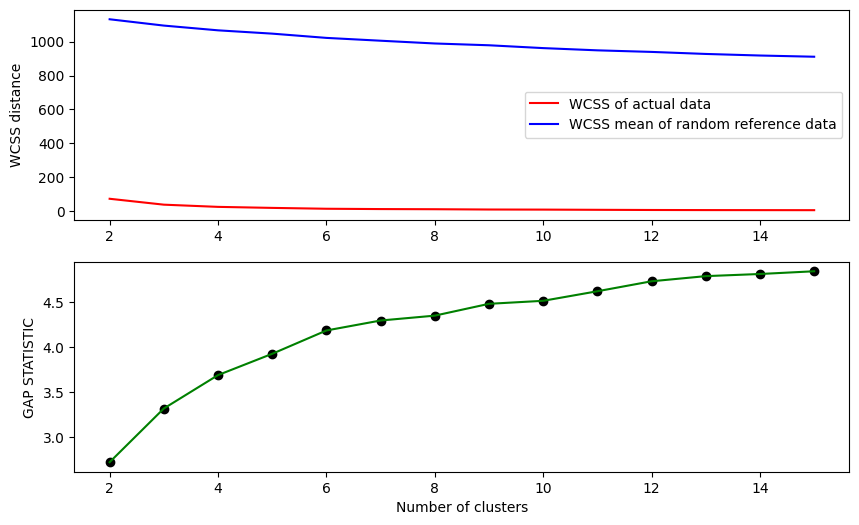

Optimal number of clusters: 15 --- out of 15 tested (using GSM)


In [ ]:
# Set the LCLid as indexes, so that the IDs are not considered for the k-means
X = df_normalized.set_index('LCLid', inplace=False)

# Chose a max number of clusters (K) to analyse
K_MAX = 15
k_range = range(2, K_MAX+1)

B = 30 # number of random reference distributions

# Apply the just created functions
gaps, stds = gap_statistic(X, k_range, B=B, plot=True)
k_opt = optimal_k(gaps, stds, k_range)


print(f"Optimal number of clusters: {int(k_opt)} --- out of {max(k_range)} tested (using GSM)")

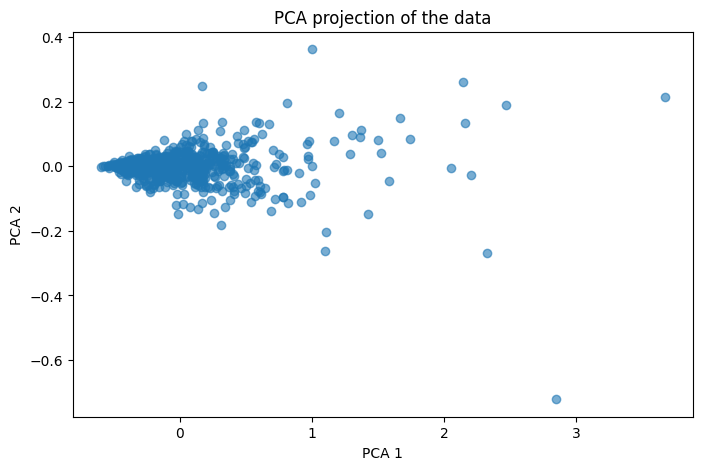

In [ ]:
# Plot the features to check possible patterns
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,5))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA projection of the data')
plt.show()


### Apply K-means clustering algorithm

In [ ]:
def apply_Kmeans(n_clusters:int):
    '''Uses KMeans methodfor n. clustes K from 2 to 7;
    prints places for all clusters and plot them;
    returns a list of dicts, each of them representing a cluster'''

    df_extracted_array = np.array(df_extracted.drop(columns='LCLid'))
    # Call the instance
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto").fit(df_extracted_array)
    # Get sn array with the labels of the centroids
    labels_arr = kmeans.labels_
    # Get an array with the coordinates of the centroids
    centroids_arr = kmeans.cluster_centers_

    return labels_arr, centroids_arr

In [ ]:
# If the GAP STATISTIC METHOD does not find a local max -> do manual selection of "k_opt"
k_opt = 6 # <--
# Apply K-means with k_opt clusters
labels_arr, centroids_arr = apply_Kmeans(n_clusters=k_opt)


In [ ]:
# Create a new dataframe that associates each LCLid with its cluster
df_clusters = pd.DataFrame({'LCLid': df_extracted['LCLid'], 'cluster': labels_arr.tolist()})
df_clusters

,LCLid,cluster
0,MAC000002,5
1,MAC000005,0
2,MAC000017,0
3,MAC000026,2
4,MAC000030,5
...,...,...
745,MAC005509,5
746,MAC005517,0
747,MAC005523,5
748,MAC005550,5


In [ ]:
# Create a new dataframe with the extracted features and the cluster_id relative to each household
df_extracted_norm_clusters = pd.merge(df_normalized, df_clusters, on='LCLid')
# Save it into a .csv file
df_extracted_norm_clusters.to_csv(drive_folder_path + 'data/df_extracted_norm_clusters.csv', index=False)
df_extracted_norm_clusters


,LCLid,TKWh,Avg_hourly,Avg_daily,Avg_weekly,Avg_monthly,Avg_Mon,Avg_Tue,Avg_Wed,Avg_Thu,...,Avg_Sat,Avg_Sun,Avg_weekend,Avg_workday,Avg_EAN,Avg_EM,Avg_LAN,Avg_M,Avg_N,cluster
0,MAC000002,0.092808,0.119064,0.119091,0.092730,0.092748,0.106704,0.115783,0.116458,0.110815,...,0.129685,0.136349,0.133041,0.113841,0.101038,0.058083,0.139120,0.134053,0.108316,5
1,MAC000005,0.044275,0.044815,0.044814,0.044193,0.044212,0.047150,0.043271,0.043760,0.040864,...,0.046777,0.048089,0.047438,0.043839,0.056807,0.033419,0.053597,0.043171,0.027675,0
2,MAC000017,0.079150,0.062699,0.062711,0.079071,0.079089,0.058711,0.054760,0.066287,0.060508,...,0.065469,0.070808,0.068158,0.060662,0.069390,0.041732,0.067978,0.070293,0.046751,0
3,MAC000026,0.154388,0.122669,0.122716,0.154316,0.154332,0.145715,0.139435,0.146693,0.133019,...,0.084117,0.096136,0.090169,0.134817,0.101975,0.118212,0.098477,0.165218,0.100686,2
4,MAC000030,0.141243,0.112202,0.112246,0.141169,0.141186,0.110712,0.084389,0.094108,0.096926,...,0.135740,0.176306,0.156168,0.095785,0.144518,0.077225,0.124258,0.126159,0.069790,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,MAC005509,0.126173,0.119666,0.119680,0.126098,0.126115,0.113873,0.115036,0.124680,0.114559,...,0.116959,0.136897,0.126999,0.116934,0.134986,0.048159,0.134721,0.135240,0.100459,5
746,MAC005517,0.027365,0.025766,0.025768,0.027281,0.027300,0.024903,0.024712,0.024222,0.024152,...,0.029368,0.027812,0.028584,0.024719,0.032582,0.024752,0.015789,0.031528,0.020542,0
747,MAC005523,0.093760,0.088869,0.088873,0.093683,0.093700,0.089755,0.085236,0.088128,0.083641,...,0.090498,0.100008,0.095287,0.086487,0.087241,0.052036,0.098956,0.087040,0.080060,5
748,MAC005550,0.122036,0.115898,0.115918,0.121961,0.121978,0.111327,0.112256,0.117332,0.109716,...,0.120665,0.130656,0.125696,0.112250,0.121590,0.059356,0.131424,0.106164,0.106820,5


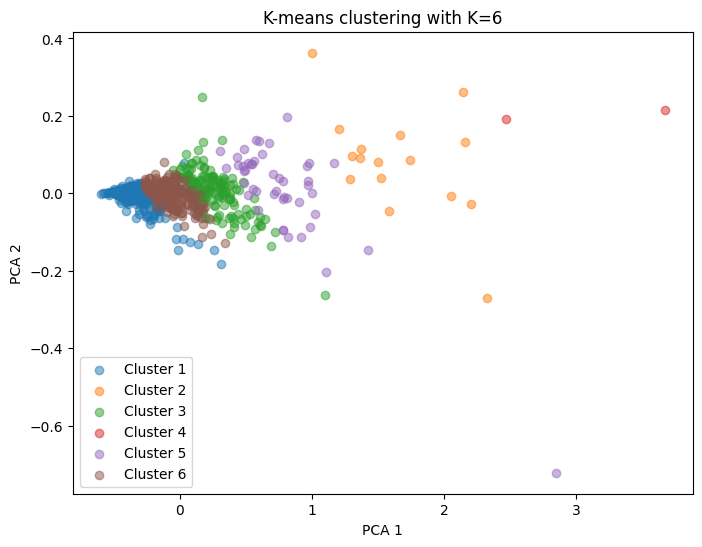

In [ ]:
# Plot the data as PCA in 2-D with the clusters
plt.figure(figsize=(8,6))
for i in range(k_opt):
    plt.scatter(X_pca[labels_arr==i,0], X_pca[labels_arr==i,1], alpha=0.5, label=f'Cluster {i+1}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.title(f'K-means clustering with K={k_opt}')
plt.show()


In [ ]:
# Display a dataframe with the wieghts for each features to create the Principal Components
weights_pca = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1','PC2'])
weights_pca

,TKWh,Avg_hourly,Avg_daily,Avg_weekly,Avg_monthly,Avg_Mon,Avg_Tue,Avg_Wed,Avg_Thu,Avg_Fri,Avg_Sat,Avg_Sun,Avg_weekend,Avg_workday,Avg_EAN,Avg_EM,Avg_LAN,Avg_M,Avg_N
PC1,0.213832,0.235396,0.235314,0.218535,0.217545,0.228849,0.228786,0.240816,0.231443,0.230538,0.244711,0.244397,0.244553,0.231986,0.248443,0.170925,0.227894,0.250331,0.200525
PC2,0.529493,-0.066325,-0.064669,0.428856,0.450745,-0.057130,-0.017315,-0.078859,-0.071090,-0.067054,-0.095637,-0.081801,-0.088669,-0.058049,-0.203411,-0.245946,-0.268211,-0.131604,0.294012


<Figure size 1000x600 with 0 Axes>

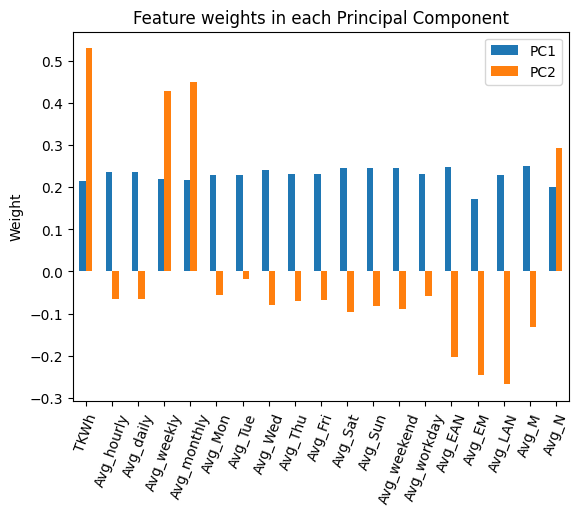

In [ ]:
'''Bar plot showing the weights of each feature in the principal components.
These weights indicate how much each feature contributes to explaining the variability of the dataset.
PC1 and PC2 are orthogonal to each other in the features-space. '''

plt.figure(figsize=(10,6))
weights_pca.T.plot(kind='bar')
plt.xticks(rotation=70)
plt.title("Feature weights in each Principal Component")
plt.ylabel("Weight")
plt.legend()
plt.show()
